# Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & \pi & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 25 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.cartpole.CartpoleCost()
model = pddp.examples.cartpole.CartpoleDynamicsModel(DT)
env = pddp.examples.cartpole.CartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta_dot = X[:, 3]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, state, Z, U, J_opt):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, state, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = 0 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U, state = controller.fit(U, encoding=ENCODING, n_iterations=1, tol=0,
                             on_iteration=on_iteration, u_min=torch.tensor([-10.0]),
                             u_max=torch.tensor([10.0]))


iteration 1 iLQRState.ACCEPTED 28.999105 [ 0.00732736  0.01332101 -0.1230782  -0.0263117 ]



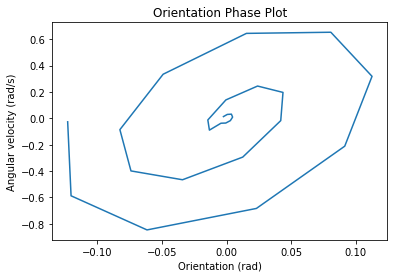

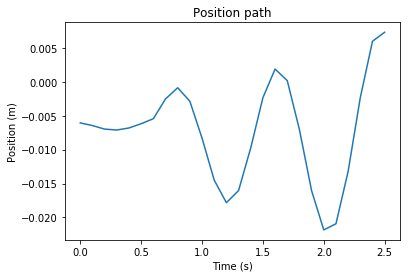

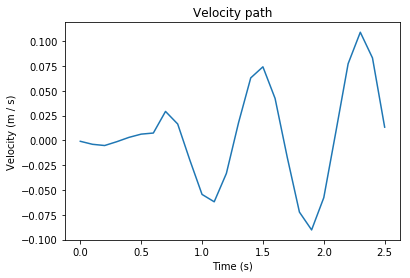

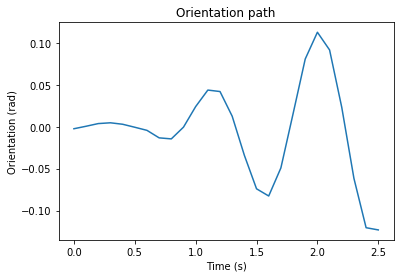

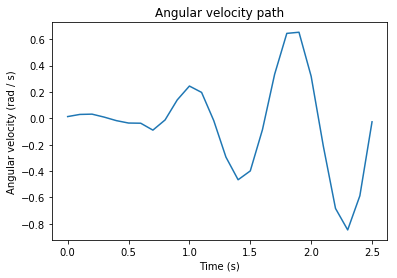

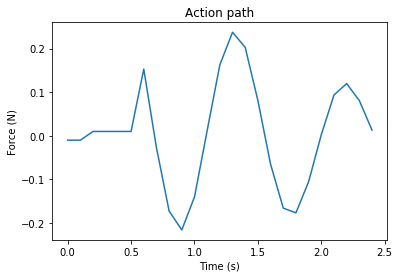

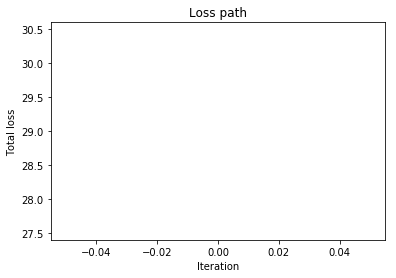

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
for i in range(10 * N):
    z = env.get_state().encode(ENCODING)
    u = controller(z, i, ENCODING, mpc=True, on_iteration=on_iteration)
    env.apply(u)

iteration 1 iLQRState.NOT_PD 29.01687 [-0.01245154  0.01673171 -0.12493098 -0.07475722]
iteration 1 iLQRState.NOT_PD 29.01687 [-0.01245154  0.01673171 -0.12493098 -0.07475722]
iteration 1 iLQRState.NOT_PD 29.01687 [-0.01245154  0.01673171 -0.12493098 -0.07475722]
iteration 1 iLQRState.NOT_PD 29.01687 [-0.01245154  0.01673171 -0.12493098 -0.07475722]
iteration 1 iLQRState.NOT_PD 29.01687 [-0.01245154  0.01673171 -0.12493098 -0.07475722]
iteration 1 iLQRState.CONVERGED 28.956995 [ 0.02753816  0.01948712 -0.21450102 -0.02925879]
iteration 2 iLQRState.NOT_PD 29.880033 [ 0.01746545 -0.1007271  -0.11948061  0.95020413]
iteration 2 iLQRState.NOT_PD 29.880033 [ 0.01746545 -0.1007271  -0.11948061  0.95020413]
iteration 2 iLQRState.NOT_PD 29.880033 [ 0.01746545 -0.1007271  -0.11948061  0.95020413]
iteration 2 iLQRState.NOT_PD 29.880033 [ 0.01746545 -0.1007271  -0.11948061  0.95020413]
iteration 2 iLQRState.NOT_PD 29.880033 [ 0.01746545 -0.1007271  -0.11948061  0.95020413]
iteration 2 iLQRState.C

iteration 69 iLQRState.CONVERGED 1.7635035e-05 [-2.07242745e-04 -1.17417869e-04  3.14156938e+00  1.11615045e-05]
iteration 70 iLQRState.CONVERGED 1.3964116e-05 [-1.8363632e-04 -7.5445845e-05  3.1415737e+00  5.4741195e-06]
iteration 71 iLQRState.CONVERGED 1.1028833e-05 [-1.6182676e-04 -4.2348809e-05  3.1415777e+00  1.2576820e-06]
iteration 72 iLQRState.CONVERGED 8.686194e-06 [-1.3859972e-04 -1.2523458e-05  3.1415811e+00 -2.9407965e-06]
iteration 73 iLQRState.CONVERGED 6.825453e-06 [-1.1648022e-04  1.0357022e-05  3.1415844e+00 -5.4974153e-06]
iteration 74 iLQRState.CONVERGED 5.3526855e-06 [-9.6129043e-05  2.8338711e-05  3.1415868e+00 -8.0001028e-06]
iteration 75 iLQRState.CONVERGED 4.1915346e-06 [-7.6806624e-05  4.1615443e-05  3.1415892e+00 -9.1657248e-06]
iteration 76 iLQRState.CONVERGED 3.2802106e-06 [-6.0502240e-05  5.0786799e-05  3.1415911e+00 -1.0004088e-05]
iteration 77 iLQRState.CONVERGED 2.566892e-06 [-4.5676705e-05  5.7278507e-05 -3.1415925e+00 -1.0453442e-05]
iteration 78 iLQRS

iteration 124 iLQRState.REJECTED 3.5665533e-11 [ 1.6968933e-08  5.2505538e-07  3.1415925e+00 -1.0685635e-06]
iteration 124 iLQRState.REJECTED 3.5665533e-11 [ 1.6968933e-08  5.2505538e-07  3.1415925e+00 -1.0685635e-06]
iteration 124 iLQRState.REJECTED 3.5665533e-11 [ 1.6968933e-08  5.2505538e-07  3.1415925e+00 -1.0685635e-06]
iteration 124 iLQRState.REJECTED 3.5665533e-11 [ 1.6968933e-08  5.2505538e-07  3.1415925e+00 -1.0685635e-06]
iteration 124 iLQRState.REJECTED 3.5665533e-11 [ 1.6968933e-08  5.2505538e-07  3.1415925e+00 -1.0685635e-06]
iteration 124 iLQRState.CONVERGED 3.513566e-11 [-3.0428799e-07  3.3350940e-07  3.1415925e+00 -9.4081997e-07]
iteration 125 iLQRState.CONVERGED 2.8901026e-11 [-2.6524270e-07  3.8994435e-07  3.1415925e+00 -1.0290617e-06]
iteration 126 iLQRState.REJECTED 2.4731855e-11 [-2.2071549e-07  4.4527204e-07  3.1415925e+00 -1.1206262e-06]
iteration 126 iLQRState.REJECTED 2.4731855e-11 [-2.2071549e-07  4.4527204e-07  3.1415925e+00 -1.1206262e-06]
iteration 126 iLQR

iteration 173 iLQRState.CONVERGED 9.075176e-12 [-3.4740978e-08  1.7301238e-07  3.1415925e+00 -6.9689605e-07]
iteration 174 iLQRState.CONVERGED 9.300315e-12 [-1.5519932e-08  1.9031245e-07  3.1415925e+00 -9.0254406e-07]
iteration 175 iLQRState.CONVERGED 9.605721e-12 [ 5.1810449e-09  2.0690396e-07  3.1415925e+00 -1.1103164e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.REJECTED 9.992196e-12 [ 2.7483148e-08  2.2302103e-07  3.1415923e+00 -1.3195126e-06]
iteration 176 iLQRState.C

iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.REJECTED 1.2415603e-11 [ 5.3815717e-07 -2.6304500e-07 -3.1415925e+00  9.6801193e-07]
iteration 216 iLQRState.CONVERGED 1.22707036e-11 [ 5.2471398e-07 -3.0416152e-07 -3.1415925e+00  8.4466194e-07]
iteration 217 iLQRState.CONVERGED 1.2341048e-11 [2.5351511e-07 1.2020048e-06 3.1415925e+00 1.8894565e-07]
iteration 218 iLQRState.CONVERGED 1.0637059e-11 [ 5.0548103e-08 -9.9878582e-07 -3.1415925e+00  3.5283756e-07]
iteration 219 iLQRS

In [16]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [17]:
for i in range(10):
    env.apply(torch.zeros_like(u))

In [18]:
env.close()